In [1]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms
from torchvision.models import resnet50
# from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os


In [2]:
class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.samples = self._retrieve_samples()

    def _retrieve_samples(self):
        samples = []
        label_map = {0: 0, 2: 1, 4: 2, 6: 3, 9: 4}  # Map original labels to a range starting from 0
        for label_dir in os.listdir(self.image_folder):
            label_folder_path = os.path.join(self.image_folder, label_dir)
            for img_name in os.listdir(label_folder_path):
                if img_name.endswith('.TIF') or img_name.endswith('.tif'):
                    img_path = os.path.join(label_folder_path, img_name)
                    original_label = int(label_dir)
                    label = label_map[original_label]  # Remap the label
                    samples.append((img_path, label))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes=5, image_pretrained=True):  # Default to 5 if not provided
        super(ImageClassifier, self).__init__()
        self.resnet = resnet50(pretrained=image_pretrained)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Ensure this matches the remapped number of classes

    def forward(self, images):
        # Pass the images through the ResNet model
        output = self.resnet(images)
        return output


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the model
num_classes = 5  # You have 5 classes according to your folder structure
model = ImageClassifier(num_classes=num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Image Transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the dataset
image_folder = 'ML/data/images'
dataset = ImageDataset(image_folder, transform=image_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


/notebooks/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/notebooks/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 438MB/s]


In [5]:
from tqdm import tqdm

In [6]:
# Initialize a list to store loss values
epoch_losses = []

# Training Loop
num_epochs = 10  # Set the number of epochs
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print statistics
    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    epoch_losses.append(loss.item())
    

 10%|█         | 1/10 [03:22<30:19, 202.19s/it]

Epoch 1/10, Loss: 0.5593


 20%|██        | 2/10 [07:05<28:36, 214.51s/it]

Epoch 2/10, Loss: 0.2304


 30%|███       | 3/10 [11:19<27:08, 232.58s/it]

Epoch 3/10, Loss: 0.0945


 40%|████      | 4/10 [14:51<22:27, 224.55s/it]

Epoch 4/10, Loss: 0.0490


 50%|█████     | 5/10 [18:39<18:48, 225.73s/it]

Epoch 5/10, Loss: 0.0988


 60%|██████    | 6/10 [22:16<14:50, 222.66s/it]

Epoch 6/10, Loss: 0.0479


 70%|███████   | 7/10 [25:32<10:42, 214.12s/it]

Epoch 7/10, Loss: 0.0895


 80%|████████  | 8/10 [28:09<06:32, 196.02s/it]

Epoch 8/10, Loss: 0.0497


 90%|█████████ | 9/10 [28:41<02:24, 144.75s/it]

Epoch 9/10, Loss: 0.0153


100%|██████████| 10/10 [29:18<00:00, 175.86s/it]

Epoch 10/10, Loss: 0.0573


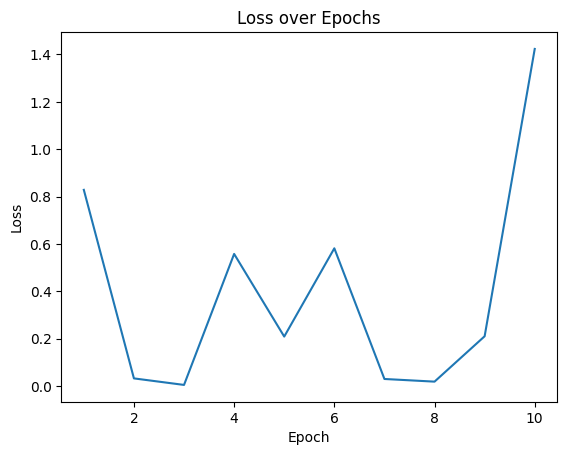

In [7]:
import matplotlib.pyplot as plt

# After training, plot the loss over epochs
plt.plot(range(1, num_epochs + 1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

In [8]:
# Save the model checkpoint
torch.save(model.state_dict(), 'models/model_res.pth')

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from torch.utils.data import Subset
import numpy as np

# Function to calculate evaluation metrics
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    
    return accuracy, precision, recall, f1, conf_matrix


In [10]:

from sklearn.model_selection import train_test_split

# Assuming dataset is an instance of ImageDataset
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.8, random_state=42)  # Change random_state for different shuffles

# Create test dataloader
test_dataset = Subset(dataset, test_indices)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load your model
model_path = 'models/model_res.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)

# Evaluate the model
accuracy, precision, recall, f1, conf_matrix = evaluate_model(model, test_dataloader)

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.998
Precision: 0.9980049685699478
Recall: 0.998
F1 Score: 0.997999974636187
Confusion Matrix:
[[399   0   0   0   0]
 [  1 391   0   0   0]
 [  0   0 394   0   1]
 [  0   0   2 394   0]
 [  0   0   0   0 418]]


In [11]:
# Original label mapping
label_map = {0: 0, 2: 1, 4: 2, 6: 3, 9: 4}

# Reverse label mapping
reverse_label_map = {v: k for k, v in label_map.items()}


In [12]:
def predict_image(model, image_path, transform, reverse_label_map):
    model.eval()  # Set the model to evaluation mode
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class_index = predicted.item()  # Get the predicted class index
        predicted_class = reverse_label_map[predicted_class_index]  # Reverse map to original label
    
    return predicted_class  # Return the predicted original class label



Predicted class: 2


In [15]:
model_path = 'models/model_res.pth'

# If you originally trained on a GPU and are now loading on a CPU:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# If you are loading on the same device type as you trained on:
model.load_state_dict(torch.load(model_path))

model.eval()  # Set the model to inference mode


ImageClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [16]:
# Usage
image_path = 'ML/data/images/2/00aecc1c-5538-46ac-900c-f9a7474fcdd1.TIF'
predicted_class = predict_image(model, image_path, image_transform, reverse_label_map)
print(f'Predicted class: {predicted_class}')

Predicted class: 2


In [17]:
image_path = 'ML/data/images/6/048e3d41-881e-496f-8602-50208574216f.TIF'
predicted_class = predict_image(model, image_path, image_transform, reverse_label_map)
print(f'Predicted class: {predicted_class}')

Predicted class: 6


In [18]:
image_path = 'ML/data/images/9/28fd31cf-b43e-48aa-abb1-8201ded9749e.TIF'
predicted_class = predict_image(model, image_path, image_transform, reverse_label_map)
print(f'Predicted class: {predicted_class}')

Predicted class: 9
